In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.calibration import calibration_curve
from sklearn.dummy import DummyClassifier
import sklearn.datasets

np.set_printoptions(threshold=5)  # to limit printing

from vflow import Vset, init_args, dict_to_df, evaluate_uncertainty, dict_keys
from vflow.pipeline import build_graph

# basic pipeline

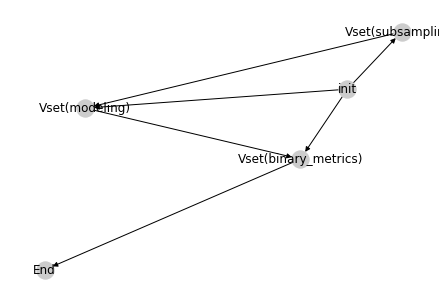

In [63]:
# initialize data
np.random.seed(13)
X, y = sklearn.datasets.make_classification(n_samples=50, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = init_args(
    (X_train, X_test, y_train, y_test),
    names=['X_train', 'X_test', 'y_train', 'y_test']  # optionally name the args
)

# subsample data
subsampling_funcs = [
    partial(sklearn.utils.resample, n_samples=20, random_state=i)
    for i in range(3)
]
subsampling_set = Vset(name='subsampling',
                       modules=subsampling_funcs,
                       output_matching=True)
X_trains, y_trains = subsampling_set(X_train, y_train)

# fit models
models = [LogisticRegression(max_iter=1000, tol=0.1), DecisionTreeClassifier()]
modeling_set = Vset(name='modeling',
                    modules=models,
                    module_keys=["LR", "DT"])

modeling_set.fit(X_trains, y_trains)
preds_test = modeling_set.predict(X_test)
preds_proba = modeling_set.predict_proba(X_test)

# get metrics
binary_metrics_set = Vset(name='binary_metrics',
                          modules=[accuracy_score, balanced_accuracy_score],
                          module_keys=["Acc", "Bal_Acc"])

binary_metrics = binary_metrics_set.evaluate(preds_test, y_test)

G = build_graph(binary_metrics, draw=True)
plt.show()

#inspect the pipeline
# for k1, v1 in hard_metrics.items():
#     print('output', k1)

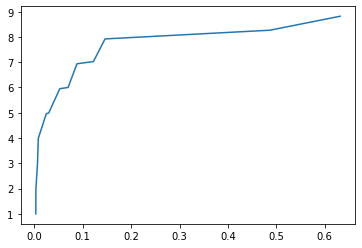

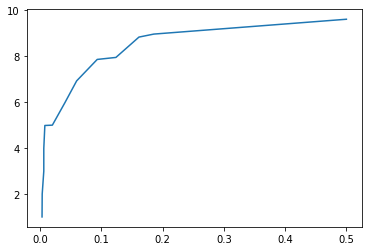

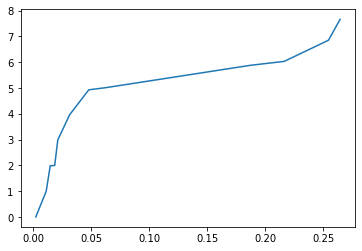

In [72]:
mean_dict, std_dict = modeling_set.predict_with_uncertainties(X_test, group_by=['subsampling'], proba=True)
u, c = evaluate_uncertainty(mean_dict, std_dict)
for i in range(u.shape[0]):
    plt.plot(u[i], c[i])
    plt.show()

In [73]:
df = dict_to_df(binary_metrics)
df

,init-subsampling,init-subsampling,subsampling,init-modeling,modeling,init-binary_metrics,binary_metrics,out
0,X_test,X_train,subsampling_0,y_train,LR,y_test,Acc,0.923077
1,X_test,X_train,subsampling_1,y_train,LR,y_test,Acc,0.923077
2,X_test,X_train,subsampling_2,y_train,LR,y_test,Acc,0.846154
3,X_test,X_train,subsampling_0,y_train,DT,y_test,Acc,0.769231
4,X_test,X_train,subsampling_1,y_train,DT,y_test,Acc,0.846154
5,X_test,X_train,subsampling_2,y_train,DT,y_test,Acc,0.846154
6,X_test,X_train,subsampling_0,y_train,LR,y_test,Bal_Acc,0.944444
7,X_test,X_train,subsampling_1,y_train,LR,y_test,Bal_Acc,0.944444
8,X_test,X_train,subsampling_2,y_train,LR,y_test,Bal_Acc,0.837500
9,X_test,X_train,subsampling_0,y_train,DT,y_test,Bal_Acc,0.763889


# feature engineering pipeline
**this data set predicts boston house-preices dataset (regression)**

{(X_train, feat_extraction_0, y_train, DT): DecisionTreeRegressor(), (X_train, feat_extraction_1, y_train, DT): DecisionTreeRegressor(), (X_train, feat_extraction_0, y_train, RF): RandomForestRegressor(), (X_train, feat_extraction_1, y_train, RF): RandomForestRegressor(), '__prev__': (<vflow.vset.Vset object at 0x7ff2a420cc88>,)}
dict_keys([(X_train, feat_extraction_0), (X_train, feat_extraction_1), '__prev__'])
dict_keys([(X_train, feat_extraction_0, X_train, y_train, DT), (X_train, feat_extraction_1, X_train, y_train, DT), (X_train, feat_extraction_0, X_train, y_train, RF), (X_train, feat_extraction_1, X_train, y_train, RF), '__prev__'])


/Users/rush/Desktop/binyugroup/veridical-flow/vflow/pipeline.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


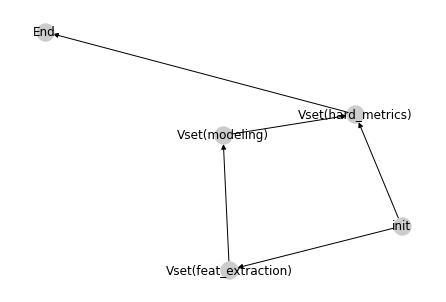

In [5]:
# get data as df
np.random.seed(13)
data = sklearn.datasets.load_boston()
df = pd.DataFrame.from_dict(data['data'])
df.columns = data['feature_names']
y = data['target']
X_train, X_test, y_train, y_test = init_args(train_test_split(df, y, random_state=123),
                                             names=['X_train', 'X_test', 'y_train', 'y_test'])


# feature extraction - extracts two different sets of features from the same data
def extract_feats(df: pd.DataFrame, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']):
    '''extract specific columns from dataframe
    '''
    return df[feat_names]


feat_extraction_funcs = [partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS']),
                         partial(extract_feats, feat_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE']),
                         ]
feat_extraction = Vset(name='feat_extraction', modules=feat_extraction_funcs, output_matching=True)

X_feats_train = feat_extraction(X_train)
X_feats_test = feat_extraction(X_test)

modeling_set = Vset(name='modeling',
                    modules=[DecisionTreeRegressor(), RandomForestRegressor()],
                    module_keys=["DT", "RF"])

# how can we properly pass a y here so that it will fit properly?
# this runs, but modeling_set.out is empty
_ = modeling_set.fit(X_feats_train, y_train)

print(modeling_set.out)
# #get predictions
preds_all = modeling_set.predict(X_feats_train)
print(X_feats_train.keys())
print(preds_all.keys())

# y_test_dict = {('data_0', 'feat_extraction_0'): y_test['X_test'], ('data_0', 'feat_extraction_1'): y_test['X_test']}

#get metrics
hard_metrics_set = Vset(name='hard_metrics',
                        modules=[r2_score],
                        module_keys=["r2"])
hard_metrics = hard_metrics_set.evaluate(preds_all, y_train)

# inspect the pipeline
#for k in hard_metrics:
#     print(k, hard_metrics[k])
G = build_graph(hard_metrics, draw=True)
plt.show()

In [6]:
df = dict_to_df(hard_metrics)
df

,init-feat_extraction,feat_extraction,init-modeling,init-modeling,modeling,init-hard_metrics,hard_metrics,out
0,X_train,feat_extraction_0,X_train,y_train,DT,y_train,r2,0.998077
1,X_train,feat_extraction_1,X_train,y_train,DT,y_train,r2,1.000000
2,X_train,feat_extraction_0,X_train,y_train,RF,y_train,r2,0.853197
3,X_train,feat_extraction_1,X_train,y_train,RF,y_train,r2,0.963828


In [7]:
X_feats_test.keys()

dict_keys([(X_test, feat_extraction_0), (X_test, feat_extraction_1), '__prev__'])

In [8]:
for k in preds_all.keys():
    print(k)

(X_train, feat_extraction_0, X_train, y_train, DT)
(X_train, feat_extraction_1, X_train, y_train, DT)
(X_train, feat_extraction_0, X_train, y_train, RF)
(X_train, feat_extraction_1, X_train, y_train, RF)
__prev__


In [42]:
len(hard_metrics)

5